In [2]:
import argparse
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
from intern.utils.parallel import block_compute
import configparser
import requests
import numpy as np
from numpy import genfromtxt
import shutil
import blosc
from IPython.core.debugger import set_trace
import sys
import os
import itertools
from functools import partial
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
from multiprocessing import cpu_count
import csv
import datetime
import seaborn as sns
from intern.utils.parallel import block_compute
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
CONFIG_FILE = 'config.ini'

In [3]:
COLL_NAME      = 'collman' 
EXP_NAME       = 'M247514_Rorb_1_Site3Align2_EM'
ANNO_NAME       = 'm247514_Site3Annotation_MN_global'
#COORD_FRAME    = 'collman_M247514_Rorb_1_Site3Align2_LENS_Session1_CROP'
CONFIG_FILE    = 'config.ini'

#CHAN_NAMES = ['Synapsin647']
#CHAN_NAMES = ['DAPI1st', 'DAPI2nd', 'DAPI3rd', 'GABA488', 'GAD647',
#        'gephyrin594', 'GS594', 'MBP488', 'NR1594', 'PSD95_488',
#        'Synapsin647', 'VGluT1_647']
#CHAN_NAMES = ['synapsin', 'PSDr'] 


In [4]:
config = configparser.ConfigParser()
config.read(CONFIG_FILE)
TOKEN = config['Default']['token']
boss_url = ''.join( ( config['Default']['protocol'],'://',config['Default']['host'],'/v1/' ) )
#print(boss_url)
#'https://api.boss.neurodata.io/v1/'

#intern
rem = BossRemote(CONFIG_FILE)
                                                                                                     
cf = CoordinateFrameResource(str(COLL_NAME + '_' + EXP_NAME))
cfr = rem.get_project(cf)
anno_res = ChannelResource(ANNO_NAME, COLL_NAME, EXP_NAME, 'annotation', datatype='uint64')

ex = {'x': cfr.x_stop, 'y': cfr.y_stop, 'z': cfr.z_stop}

blocks = block_compute(0,ex['x'],0,ex['y'],0,ex['z'],
           origin = (0,0,0), block_size = (512, 512, 16))



In [5]:
rem.get_bounding_box(anno_res, 0, id = 2, bb_type = 'tight')

{'x_range': [7304, 8239],
 'y_range': [5681, 6642],
 'z_range': [27, 48],
 't_range': [0, 1]}

In [6]:
ba = [b[0] for b in blocks]
bb = [b[1] for b in blocks]
bc = [b[2] for b in blocks]
blocks

[((512, 1024), (512, 1024), (16, 32)),
 ((512, 1024), (512, 1024), (32, 48)),
 ((512, 1024), (512, 1024), (0, 16)),
 ((512, 1024), (512, 1024), (48, 49)),
 ((512, 1024), (1024, 1536), (16, 32)),
 ((512, 1024), (1024, 1536), (32, 48)),
 ((512, 1024), (1024, 1536), (0, 16)),
 ((512, 1024), (1024, 1536), (48, 49)),
 ((512, 1024), (1536, 2048), (16, 32)),
 ((512, 1024), (1536, 2048), (32, 48)),
 ((512, 1024), (1536, 2048), (0, 16)),
 ((512, 1024), (1536, 2048), (48, 49)),
 ((512, 1024), (2048, 2560), (16, 32)),
 ((512, 1024), (2048, 2560), (32, 48)),
 ((512, 1024), (2048, 2560), (0, 16)),
 ((512, 1024), (2048, 2560), (48, 49)),
 ((512, 1024), (2560, 3072), (16, 32)),
 ((512, 1024), (2560, 3072), (32, 48)),
 ((512, 1024), (2560, 3072), (0, 16)),
 ((512, 1024), (2560, 3072), (48, 49)),
 ((512, 1024), (3072, 3584), (16, 32)),
 ((512, 1024), (3072, 3584), (32, 48)),
 ((512, 1024), (3072, 3584), (0, 16)),
 ((512, 1024), (3072, 3584), (48, 49)),
 ((512, 1024), (3584, 4096), (16, 32)),
 ((512, 10

In [7]:
rid = []
for b in blocks:
    tmp = rem.get_ids_in_region(anno_res, 0, b[0], b[1], b[2], [0,1])
    if tmp != []:
         rid = rid + tmp
                                                                                                     
u = np.unique(np.asarray(rid))


In [8]:
def getID(a,b,c):
    out = rem.get_ids_in_region(anno_res, 0, a, b, c, [0,1])
    return(out)
    
with ThreadPool(4) as tpb:
        #out = tpb.map(getID, ba, bb, bc)
        out = tpb.starmap(getID, blocks)
    

In [54]:
rem.get_bounding_box(anno_res, 0, 2, bb_type = 'tight')

{'t_range': [0, 1],
 'x_range': [7304, 8239],
 'y_range': [5681, 6642],
 'z_range': [27, 48]}

In [ ]:
## bounding box for annotation_i
bb = [rem.get_bounding_box(anno_res, 0,ui, 'tight') for ui in u]
                                                                                                     
for i in range(len(bb)):
    bb[i]["id"] = u[i]
                                                                                                     
A = [(rem.get_cutout(
      anno_res, 0, bb[i]["x_range"], 
      bb[i]["y_range"], bb[i]["z_range"], 
      id_list = [bb[i]['id']]) != bb[i]['id']).astype(int) 
    for i in range(len(bb))] 
                                                                                                     
#Bmeans = [np.int32(np.round(np.mean(np.asarray(np.where(A[i] == True)),1))) for i in range(len(A))]
Bmeans = [np.int32(np.round(np.mean(np.asarray(np.where(A[i] == 1)),1))) for i in range(len(A))]

Bglobal = []
for i in range(len(bb)):
    ad1 = np.asarray([bb[i]['z_range'][0], bb[i]['y_range'][0], bb[i]['x_range'][0]])
    Bglobal.append(Bmeans[i] + ad1)
    
ColMin = np.asarray(bf)
ColMax = np.asarray([ex['z'] - (bf[0] + 1),  # The z index is inclusive
                     ex['y'] - (bf[1] + 1), 
                     ex['x'] - (bf[2] + 1)])
                                                                                                     
m = [Bglobal[i] >= ColMin for i in range(len(Bglobal))]
M = [Bglobal[i] <= ColMax for i in range(len(Bglobal))]
mm = [np.all(m[i]) for i in range(len(m)) ]
MM = [np.all(M[i]) for i in range(len(M)) ]
                                                                                                     
                                                                                                     

In [15]:
Bcon = []
conID = []
con = [np.asarray(mm[j] and MM[j]) for j in range(len(mm))]
for i in range(len(Bglobal)):
    if con[i]: 
        Bcon.append(Bglobal[i])
        conID.append(bb[i]['id'])

In [33]:
conID

[453, 483, 528, 531, 647, 648, 650]

In [43]:
[Bcon[i][2] - bf[2], Bcon[i][2] + bf[2]+1]

[777, 994]

In [44]:
tmp = rem.get_cutout(anno_res, 0, 
       [Bcon[i][2] - bf[2], Bcon[i][2] + bf[2]+1],
       [Bcon[i][1] - bf[1], Bcon[i][1] + bf[1]+1],
       [Bcon[i][0] - bf[0], Bcon[i][0] + bf[0]+1])

In [65]:
AA = [(rem.get_cutout(
       anno_res, 0, 
       [Bcon[i][2] - bf[2], Bcon[i][2] + bf[2]+1],
       [Bcon[i][1] - bf[1], Bcon[i][1] + bf[1]+1],
       [Bcon[i][0] - bf[0], Bcon[i][0] + bf[0]+1],
       id_list = [conID[i]]) == conID[i]).astype(np.int8) for i in range(len(Bcon))]

In [66]:
AA[0].dtype

dtype('int8')

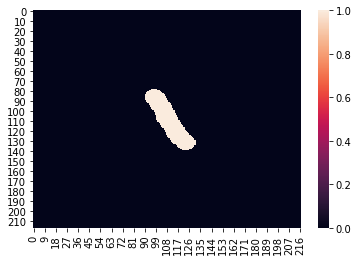

In [67]:
sns.heatmap(AA[0][6,::])

In [ ]:
   
if CHAN_NAMES is None:
            #CHAN_NAMES = ['DAPI1st', 'DAPI2nd', 'DAPI3rd',
    	#      'GABA488', 'GAD647', 'gephyrin594', 'GS594', 'MBP488',
            #      'NR1594', 'PSD95_488', 'Synapsin647', 'VGluT1_647']
            CHAN_NAMES = ['bIIItubulin', 'DAPI_2nd', 'DAPI_3rd',
                    'GABA', 'GAD2', 'gephyrin', 'NR1', 'PSDr',
                    'synapsin', 'VGAT', 'VGluT1'] 
                                                                                                     
ChanList = []
                                                                                                     
## For getting masked bounding box around centroid of annotation
for ch in CHAN_NAMES:
    di = [{
          'rem': rem,
          'ch_rsc':
            ChannelResource(ch,COLL_NAME,EXP_NAME,'image',datatype='uint8'),
          'ch'  : ch,
          'res' : 0,
          'xrng': [Bcon[i][2] - bf[2], Bcon[i][2] + bf[2] + 1], 
          'yrng': [Bcon[i][1] - bf[1], Bcon[i][1] + bf[1] + 1], 
          'zrng': [Bcon[i][0] - bf[0], Bcon[i][0] + bf[0] + 1], 
          'mask': AA[i]
         } for i in range(len(Bcon))]
    with ThreadPool(num_threads) as tp:
        out = tp.map(toolbox.getMaskData, di)
        print(ch) ##DEBUG
        sys.stdout.flush() #DEBUG
    ChanList.append(np.asarray(out))
cubes = np.asarray(ChanList)
loc = np.asarray(Bcon)